In [169]:
# %load ../utils/standard_library_import.py
%load_ext autoreload
%autoreload 2

import GoH.verify_model
import gspread
import json
from matplotlib import pyplot as plt
from oauth2client.service_account import ServiceAccountCredentials
import os
import pandas as pd
import seaborn as sns

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
# %load ../utils/import_and_preprocess_supporting_model_data.py
dataDir = "../../data/"

# Load data from Google Doc
scope = ['https://spreadsheets.google.com/feeds']
secrets = "/Users/jeriwieringa/Dissertation/dev/drafts/code/secrets/dissertation-881847769b13.json"
credentials = ServiceAccountCredentials.from_json_keyfile_name(secrets, scope)
gc = gspread.authorize(credentials)
dts = gc.open('Topic Labels').sheet1

labels = pd.DataFrame(dts.get_all_records())

with open(os.path.join(dataDir, 'params_target_300_10.18497.json')) as f:
    params = json.load(f)

metadata = pd.read_csv(os.path.join(dataDir, 'meta.csv'), header=None).reset_index()
metadata.columns = ['doc_id', 'filename', 'citation', 'author', 
                    'periodical_name', 'volume', 'issue', 
                    'date', 'page', 'abrev', 'url']
metadata['date_formatted'] = pd.to_datetime(metadata['date'])

In [27]:
dt = pd.read_csv(os.path.join(dataDir, 'dt_target_300_10.18497.csv'))

In [268]:
"""Process
- Load DT dataframe and supporting data
- Subset the dataframe according to goal of notebook
- Smooth the document/topic values by adding (alpha_sum?)
- Aggregate the values according to the year
- Normalize the rowse (time)

"""
def subset_by_set(dt, metadata, column="abrev", value=""):
    df = dt.merge(metadata, how='left', on='doc_id')
    
    return df[df[column].isin(value)]


def light_smooth(subbed_df, smooth_value):
    m = subbed_df.pivot(index="doc_id", columns="topic", values="word_counts").fillna(0)
    m = m + smooth_value
    df = m.unstack().reset_index()
    df.columns = ['topic', 'doc_id', 'word_counts']

    return df


def aggregate_by_time(df, metadata):
    df = df.merge(metadata, how="left", on="doc_id")
    
    return df.groupby([df.date_formatted.dt.year, 'topic']).agg({'word_counts': 'sum'}).reset_index()


def norm_matrix(df, verify):
    m = df.pivot(index="date_formatted", columns="topic", values="word_counts")
    m = m.div(m.sum(axis=1), axis=0)
    if verify == True:
        print(m.iloc[0].sum())
    df = m.unstack().reset_index()
    df.columns = ['topic', 'year', 'topic_proportion']
    
    return df


def prepare_data_set(df, metadata, smooth_value, subset=True, doc_set="", smooth=True, norm=True, verify=False):
    """Compilation function.
    """
    if subset == True:
        df = subset_by_set(df, metadata, value=doc_set)
    if smooth == True:
        df = light_smooth(df, smooth_value)
    df = aggregate_by_time(df, metadata)
    if norm == True:
        df = norm_matrix(df, verify)
    
    return df


def select_topics(df, columns=""):

    return df[df['topic'].isin(columns)]


def plot_select_topics(df, collection):
    df = select_topics(df, collection)
    sns.lmplot(x="year", y="topic_proportion", hue='topic', data=df, fit_reg=False, size=4, aspect=2)
    plt.ylim(0.0, 0.1)
    plt.xlim(1845, 1925)

    
def plot_sum_select_topics(df, collection):
    subset = df.pivot(index="year", columns="topic", values="topic_proportion")
    summed = subset[collection].sum(axis=1)
    sns.set_style("darkgrid")
    summed.plot(figsize=(9,5))
    plt.ylim(0.0, 0.15)
    plt.xlim(1845, 1925)

In [269]:
RH = prepare_data_set(dt, metadata, smooth_value=params['alpha_sum'], subset=True, doc_set=["RH"], smooth=True, norm=True, verify=True)
# RH = prepare_data_subset(dt, ['RH'], metadata, smooth_value=params['alpha_sum'], smooth=True, norm=True, verify=True)

1.0


In [270]:
alldata = prepare_data_set(dt, metadata, smooth_value=params['alpha_sum'], subset=False, doc_set="", smooth=True, norm=True, verify=True)

1.0


In [253]:
RH[:5]

,topic,year,topic_proportion
0,0,1850,0.002667
1,0,1851,0.002510
2,0,1852,0.002377
3,0,1853,0.002435
4,0,1854,0.002465


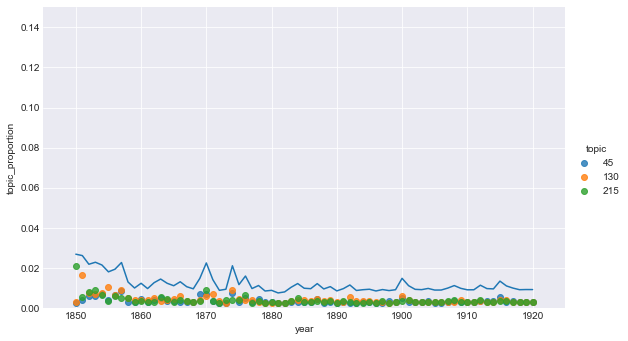

In [254]:
prophecy = [45, 130, 215]
plot_select_topics(RH, prophecy)
plot_sum_select_topics(RH, prophecy)

In [255]:
denominational_publications = ['RH', 'ST', 'ARAI', 'GCB', 'PTAR','TCOG']

In [264]:
denom = prepare_data_subset(dt, denominational_publications , metadata, smooth_value=params['alpha_sum'], smooth=True, norm=True, verify=True)

1.0


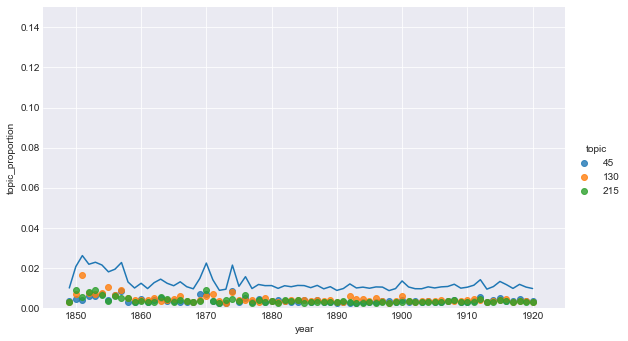

In [265]:
prophecy = [45, 130, 215]
plot_select_topics(denom, prophecy)
plot_sum_select_topics(denom, prophecy)

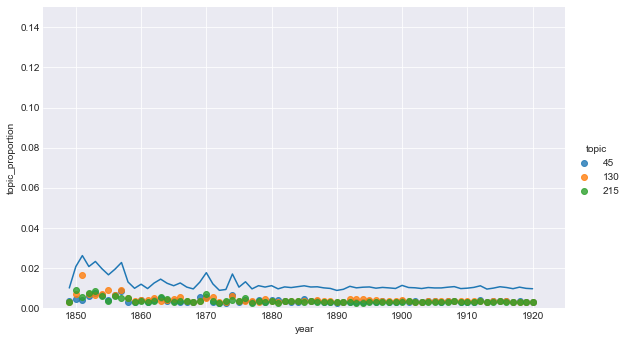

In [272]:
prophecy = [45, 130, 215]
plot_select_topics(alldata, prophecy)
plot_sum_select_topics(alldata, prophecy)